# Exploring Test Result Data

This document analyzes a single JMeter CSV results file. 
It demonstrates how to: 
- Process epoch time into readable text.
- Convert from UTC to a local time zone.
- Statistically detect outliers using Z codes.
- Find the distribution of the test samples with a histogram and gaussian kernel density estimate (KDE) curve.
- Evaluate response time with aggregate functions: min, max, mean, mode, skew, and standard deviation.
- Calcualate a rolling throughput by resampling the data set into larger time samples.

In [10]:
import numpy as np              #Provides multidimensional arrays and related capabilities.
import pandas as pd             #Statistics library that adds tables and related capabilities.
import scipy.stats as stats     #Statistic library
import matplotlib.pyplot as plt #2D plotting library that works like MATLAB.
import seaborn as sns           #Visualizations built on top of pyplot.
from IPython.display import display_html 

sns.set(style="dark")
pageWidth = 25

## Summary of Response Time

In [11]:
# Load the test results file into memory.
samples = pd.read_csv('../test_results/hello_world_results.csv')

# Process the Unix/Epoch Time to make processing easier.
# Convert to my local time zone of CST.
samples['localTime'] = ( pd.to_datetime(samples['timeStamp'],unit='ms') #convert Epoch to Date/Time
                      .dt.tz_localize('UTC')                            # Declare we're using UTC
                      .dt.tz_convert('US/Central'))                     # Convert to my local time.

### Plot of Response Time
Color is driven by request sucess. 
Size is driven by response time.

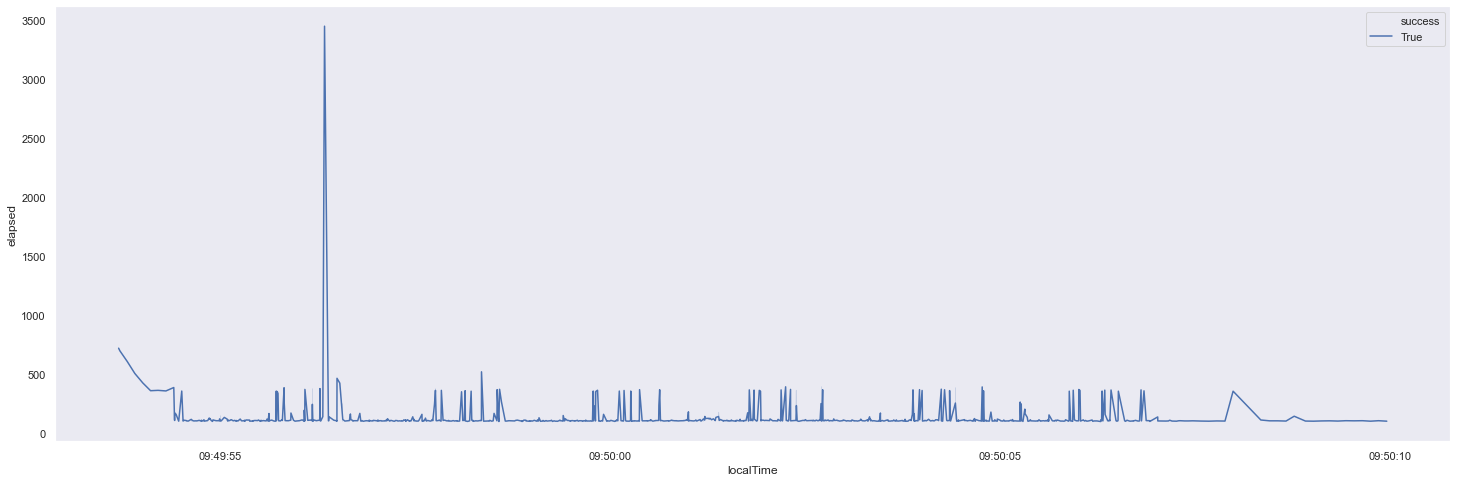

In [12]:
plt.figure(figsize=(pageWidth,8))
sns.lineplot(x="localTime", y="elapsed",
             hue="success", style="success",
             data=samples)

Outliers removed by filtering out all samples where the elapsed time has an absolute Z score of 3 or higher.
Z score signifies how much standard deviation a sample point has from the mean (average).  
More specifically:  
$\mathbf{Z} = \frac{(x - \mu)}{\sigma}$, where: $x$ = a sample, $\mu$ = the mean, and $\sigma$ = standard deviation

The higher the Z score, the more unusal the value is in the data set.

__Rule of Thumb__: If the data follows a _normal_ distribution, then exclude Z scores greater than 3.


In [13]:
# Calculate the Z Score of the elapsed time.
# We can use this to filter outliers, if needed.
samples['elapsedTimeZScore'] = stats.zscore(samples.elapsed)

# Create a second data set that filters out the outliers.
filteredSamples = samples[lambda i: np.abs(i.elapsedTimeZScore) < 3];

How does this throughput related to the overall throughput?

Signature: throughput(column)
Docstring: <no docstring>
File:      ~/Documents/Code/salesforce-dx-jmeter-example/notebooks/<ipython-input-9-3baf42da305b>
Type:      function


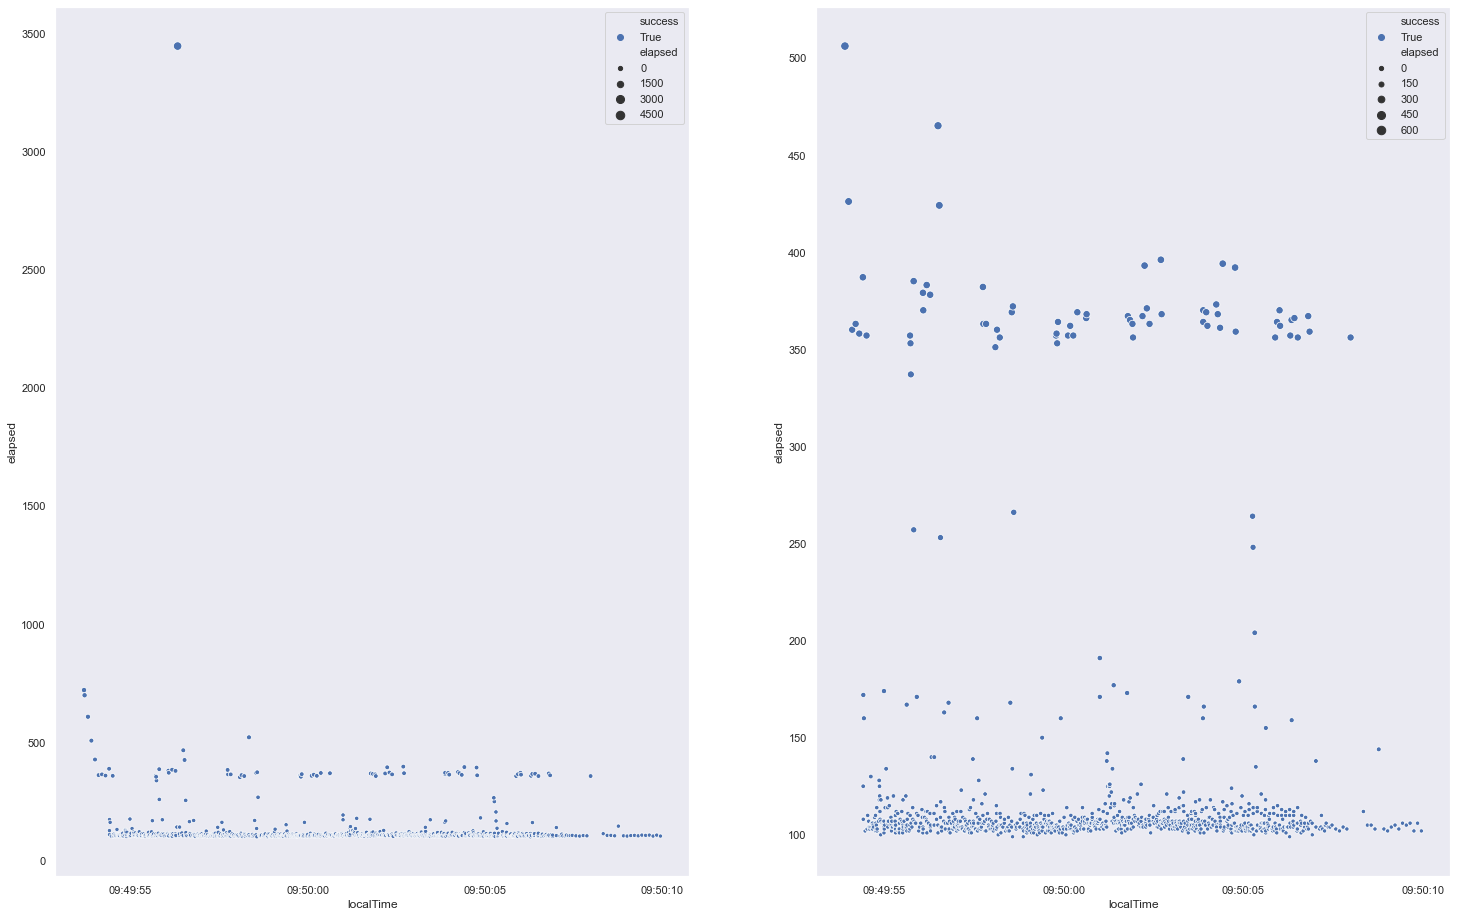

In [14]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(pageWidth,16))
sns.scatterplot(x="localTime", y="elapsed", hue="success", size="elapsed", ax=axes[0], data=samples);
sns.scatterplot(x="localTime", y="elapsed", hue="success", size="elapsed", ax=axes[1], data=filteredSamples)

### Summary Table of Response Times

In [15]:
THREASHOLD = 2000

def p90(column):
    return column.quantile(0.9)

def p95(column):
    return column.quantile(0.95)

def p99(column):
    return column.quantile(0.99)

def mode(column):
    return column.mode()

def red_when_higher_than_threshold(val):
    color = 'red' if val >= THREASHOLD else 'white'
    return 'color: %s' % color 

summaryOfOriginal = (samples.groupby("responseCode")
    .agg( {'elapsed': ['count','min', 'median', p90, p95, p99, 'max', 'mean', mode,'skew', 'std']}))

styler1 = (summaryOfOriginal.style
    .set_table_attributes("style='display:inline'")
    .set_caption('Full Data Set')
    .applymap(red_when_higher_than_threshold)
    .set_precision(0))

summaryOfFiltered = (filteredSamples.groupby("responseCode")
                     .agg( {'elapsed': ['count','min', 'median', p90, p95, p99, 'max', 'mean', mode, 'skew', 'std']}))

styler2 = (summaryOfFiltered.style
    .set_table_attributes("style='display:inline'")
    .set_caption('Outliers Removed')
    .applymap(red_when_higher_than_threshold)
    .set_precision(0))

# Render the tables side by side
display_html(styler1._repr_html_()+styler2._repr_html_(), raw=True)


Full Data Set elapsed count min median p90 p95 p99 max mean mode skew std responseCode 
 
 200 
 1000 
 99 
 106 
 142 
 360 
 394 
 3446 
 132 
 103 
 18 
 129 
 
 Outliers Removed elapsed count min median p90 p95 p99 max mean mode skew std responseCode 
 
 200 
 995 
 99 
 106 
 139 
 358 
 383 
 506 
 127 
 103 
 3 
 67

Table Definitions
- __count__ The number of samples used the calculations.
- __min__ is the minimum value in the samples.
- [median](https://en.wikipedia.org/wiki/Median) The middle point (center) of which half the values are less than.
- [p90, p95, p99](https://en.wikipedia.org/wiki/Percentile) are percentiles. A value that a percentage of samples are below.
- __max__ is the maximum value in the samples.
- [mean](https://en.wikipedia.org/wiki/Arithmetic_mean) is the arithmetic mean or rather average. The sum of values divided by the number of samples.
- [mode]() is the normal value. The value that occures the most often in the data set.
- [skew](https://en.wikipedia.org/wiki/Skewness) indicates which way the distribution is shifted. A positive skew is shifting to the left and vice versa.
- [std](https://en.wikipedia.org/wiki/Standard_deviation) is the _standard deviation_ which describes how densely the data points are around the mean value.

## The Request's distribution.
A histogram with a kernel density estimate (KDE)

Histogram of the entire sample set minus the outliers.


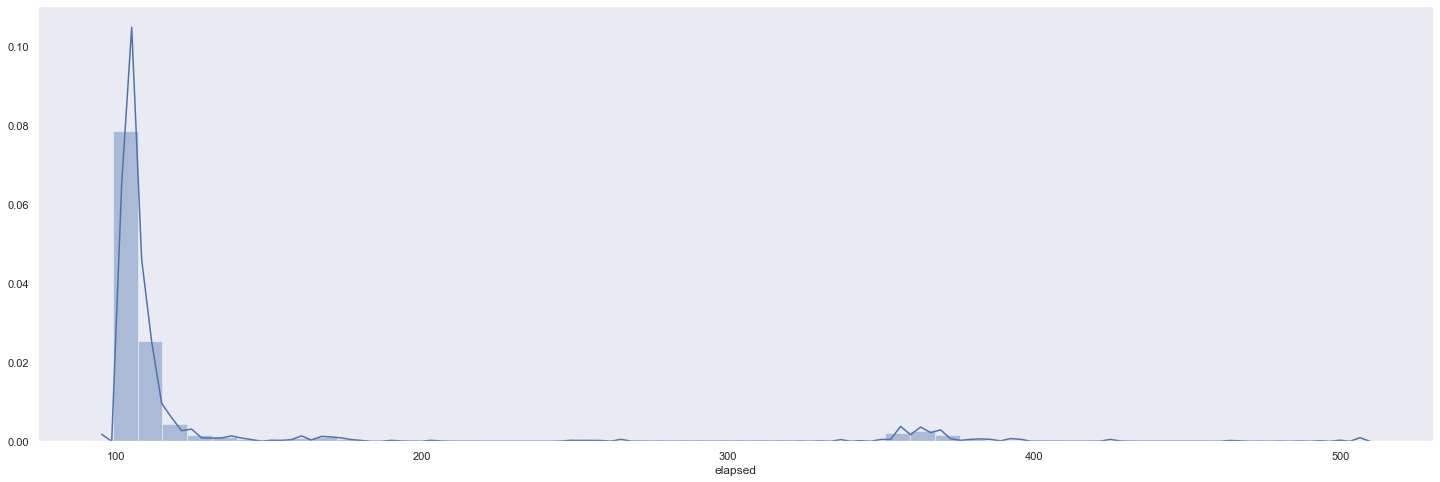

In [16]:
plt.figure(figsize=(pageWidth,8))
# sns.distplot(filteredSamples.elapsed, bins=100, kde=False, norm_hist=True)
print('Histogram of the entire sample set minus the outliers.')
sns.distplot(filteredSamples.elapsed) #Histogram of the entire set minus the outliers.

Two Histograms displaying the ranges [100,200] and [300, 400]


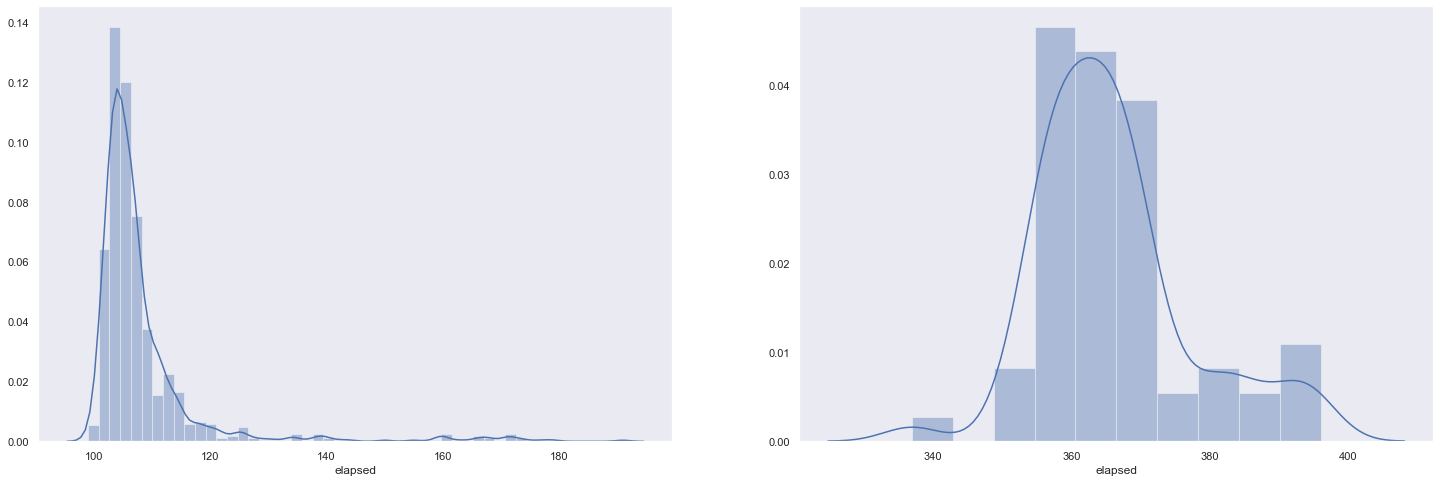

In [17]:
# Just look at the two main groups of requests.
firstRange = lambda i: i.elapsed <= 200
secondRange = lambda i: ((i.elapsed >= 300) & (i.elapsed <= 400))
firstGroup = filteredSamples[firstRange]
secondGroup = filteredSamples[secondRange]
print('Two Histograms displaying the ranges [100,200] and [300, 400]')
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(pageWidth,8)) 
sns.distplot(firstGroup.elapsed, ax=axes[0])
sns.distplot(secondGroup.elapsed, ax=axes[1])

Overall Throughput: 61.94/sec


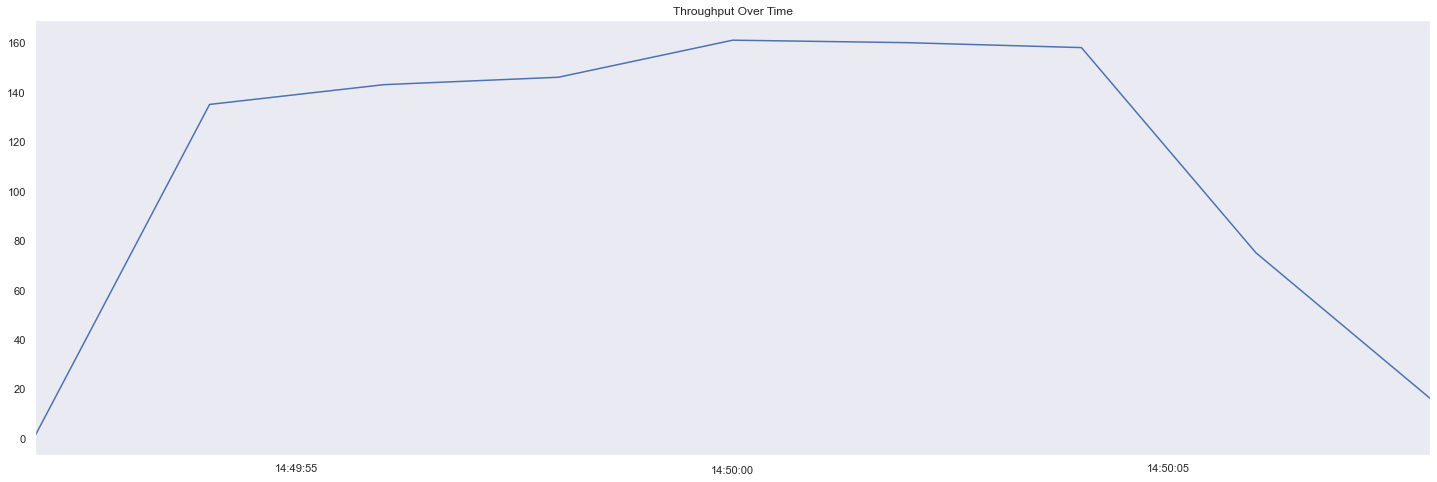

In [18]:
# Calculate Throughput in requests per second
def throughput(column):    
    start = pd.Timestamp(column.min(), unit='ms')
    stop = pd.Timestamp(column.max(), unit='ms')
    delta = stop - start # Returns a pd.Timedelta object
    duration = delta.total_seconds()
    throughput = column.count()/duration
    return throughput
    
# calculate total throughput of samples
totalThroughput = throughput(filteredSamples.timeStamp)
print('Overall Throughput: {:.2f}/sec'.format(totalThroughput))

# Try to resample the filteredSamples to 1 second bins and calculate the throughput per second.
# I'd like to graph the throughput curve over time.
# Create a DatetimeIndex from the timestamps.
# convert the column (it's Int64) to datetime type
datetime_series = pd.to_datetime(filteredSamples.timeStamp, unit='ms')

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)
fs2 = filteredSamples.set_index(datetime_index)

twoSecSampling = fs2.elapsed.resample('2S').count() 

# fs2.elapsed.plot()
# sns.lineplot(hue="success", style="success", data=fs2)
plt.figure(figsize=(pageWidth,8))
plt.title("Throughput Over Time")
twoSecSampling.plot()